In [1]:
#!pip install scikeras

In [2]:
#!pip install tensorflow

In [3]:
#!pip install xgboost


In [4]:
import pandas as pd
import numpy as np

# JSON parsing
import json

# HTML parsing
import urllib

from pyspark.ml.feature import StringIndexer

# SQLite RDBMS
import sqlite3

# Time conversions
import time

import sys
from pathlib import Path


In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("bosch").config("spark.driver.memory", "58g")
spark.config("spark.sql.autoBroadcastJoinThreshold", -1)
spark = spark.getOrCreate()


In [6]:
#dbutils.fs.mount(
#  source = "wasbs://prod@storagebosch.blob.core.windows.net",
#  mount_point = "/mnt/prod",
#  extra_configs = {"fs.azure.account.key.storagebosch.blob.core.windows.net":"whVS/3uSPo+pCWof4+AivjFcrisJqobCqOJdFZHoI551sTK982NCG1OgpjltwkTlZeJQKONeGTwl+AStANOAxA=="})


In [7]:
#dbutils.fs.ls("/mnt/prod/")


In [8]:
############### 1. Data Aquisition   ##############


In [9]:
# Read Numeric dataset
from pyspark.sql.types import *

colnames = spark.read.csv("train_numeric.csv", header=True, inferSchema=True).columns
schema = StructType([StructField("Id", IntegerType())] + [StructField(col, DoubleType()) for col in colnames if col != "Id"])
df_numeric = spark.read.csv("train_numeric.csv", header=True, schema=schema)

df_numeric = df_numeric.sample(False, 0.1, seed=123)


In [10]:
# Read Categorical dataset

from pyspark.sql.types import *

colnames = spark.read.csv("train_categorical.csv", header=True, inferSchema=True).columns
schema = StructType([StructField("Id", IntegerType())] + [StructField(col, StringType()) for col in colnames if col != "Id"])
df_category = spark.read.csv("train_categorical.csv", header=True, schema=schema)


In [11]:
# Read Date dataset
from pyspark.sql.types import *

colnames = spark.read.csv("train_date.csv", header=True, inferSchema=True).columns
schema = StructType([StructField("Id", IntegerType())] + [StructField(col, DoubleType()) for col in colnames if col != "Id"])
df_date = spark.read.csv("train_date.csv", header=True, schema=schema)


In [12]:
############## 2. Exploratory analysis ##############

In [ ]:
# Plot distribution of 3 datasets

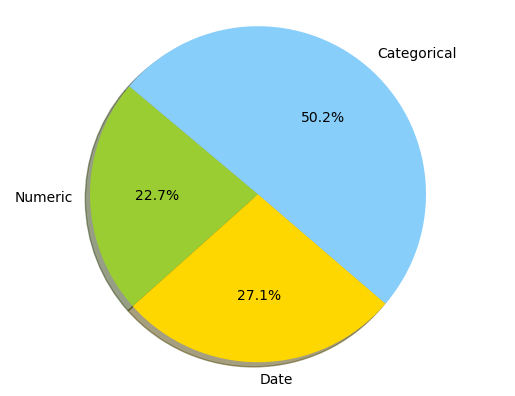

In [13]:
import matplotlib.pyplot as plt

# Data to plot
labels = 'Numeric', 'Date', 'Categorical'
sizes = [len(df_numeric.columns) -1, len(df_date.columns)-1, len(df_category.columns)-1]
colors = ['yellowgreen', 'gold', 'lightskyblue']

# Plot
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


In [ ]:
# Plot how many null values and valid values

In [14]:
# Import required functions
from pyspark.sql.functions import col, sum

# Calculate the number of missing values in the numeric columns
null_counts = df_numeric.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_numeric.columns])
null_numeric = null_counts.toPandas().values.sum()

# Calculate the number of missing values in the date columns
null_counts = df_date.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_date.columns])
null_date = null_counts.toPandas().values.sum()

# Calculate the number of missing values in the categorical columns
null_counts = df_category.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_category.columns])
null_category = null_counts.toPandas().values.sum()

# Store the number of missing values in a list
null_values = [null_numeric, null_date, null_category]

# Store all dataframes in a list
df_list = [df_numeric, df_date, df_category]

# Calculate the total number of values in each dataframe
total_values = []
for d in df_list:
    total_values.append(d.count() * len(d.columns))

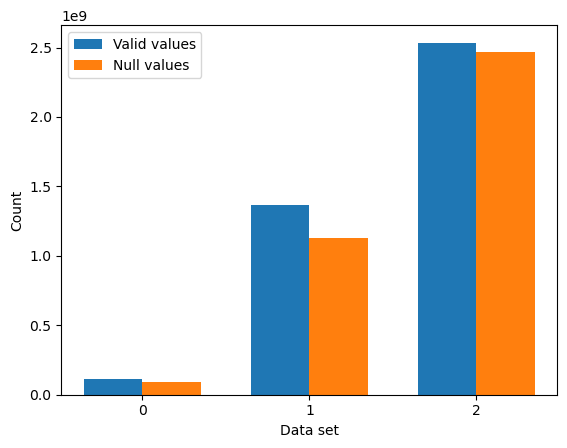

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create the chart
fig, ax = plt.subplots()
x = np.arange(len(total_values))
bar_width = 0.35
rects1 = ax.bar(x - bar_width/2, total_values, bar_width, label='Valid values')
rects2 = ax.bar(x + bar_width/2, null_values, bar_width, label='Null values')

# Add labels and legend
ax.set_ylabel('Count')
ax.set_xlabel('Data set')
ax.set_xticks(x)
ax.legend()

# Show the chart
plt.show()

In [ ]:
############## 3. Data Preparation    ############################

In [16]:
## Stratified sampling to resolve imbalanced dataset ############

In [17]:
from pyspark.sql.functions import rand

# First, we need to count the number of instances of each class in the label column
counts = df_numeric.groupBy("Response").count()

# Calculate the number of instances we want to keep for each class
minority_count = counts.filter(col("Response") == 1).collect()[0][1]
majority_count = counts.filter(col("Response") == 0).collect()[0][1]

# Downsample the majority class
downsampled_majority = df_numeric.filter((col("Response") == 0)).orderBy(rand()).limit(minority_count)

# Combine the minority and downsampled majority classes
stratified_sampled_df = df_numeric.filter(col("Response") == 1).union(downsampled_majority)

df_numeric = stratified_sampled_df

#display(df_numeric.head())

In [18]:
# Join the two dataframes on the Id column
merged_df = df_date.join(stratified_sampled_df, on='Id', how='inner')

# Select only the columns from df_date
df_date = merged_df.select(df_date.columns)

#display(df_date.head())

In [19]:
# Join the two dataframes on the Id column
merged_df = df_category.join(stratified_sampled_df, on='Id', how='inner')

# Select only the columns from df_date
df_category = merged_df.select(df_category.columns)
#display(df_category.head())

In [ ]:
#### Data cleaning

In [28]:
##### Dimensionality reduction of numeric dataset

In [21]:
df_category = df_category.na.fill('NA')

In [22]:
df_date = df_date.na.fill(0)

In [23]:
df_numeric = df_numeric.na.fill(0)

In [27]:
############## 4. Feature Extraction    ############################

In [ ]:
#### Scale the data set of PCA

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

#df_numeric = df_numeric.drop('features')

cols = [col for col in df_numeric.columns if col != 'Id' and col != 'Response']

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
  inputCols = cols,
  outputCol = "features")

#Standardizing the features based on unit variance
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

stages = [assembler, scaler]
pipeline = Pipeline(stages=stages)
# Fit the pipeline on the input DataFrame
df_numeric = pipeline.fit(df_numeric).transform(df_numeric)

In [ ]:
#### PCA

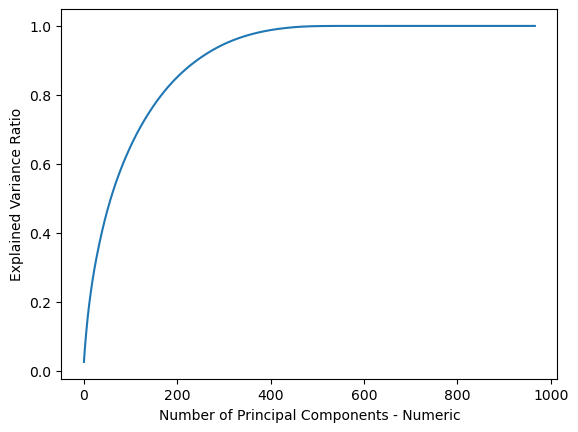

In [31]:
from pyspark.ml.feature import PCA
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import array
import numpy as np

df_numeric = df_numeric.drop('features')

#Create instance of PCA
pca = PCA(k=len(df_numeric.columns) - 4 , inputCol="scaled_features", outputCol="pca_num_features")

# fit PCA model on dense features
pca_model = pca.fit(df_numeric)

#Transform the DataFrame
df_numeric = pca_model.transform(df_numeric)

# access the explained variance ratio for each principal component
explained_variance = pca_model.explainedVariance
pc_vs_variance = np.cumsum(pca_model.explainedVariance)

# plot the explained variance ratio
plt.plot(pc_vs_variance)
plt.xlabel('Number of Principal Components - Numeric')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [ ]:
#### Reduce to 400 features per the explained variance ratio

In [32]:
df_numeric = df_numeric.drop('pca_num_features')

#Create instance of PCA
pca = PCA(k=400 , inputCol="scaled_features", outputCol="pca_num_features")

# fit PCA model on dense features
pca_model = pca.fit(df_numeric)

#Transform the DataFrame
df_numeric = pca_model.transform(df_numeric)

In [34]:
####### Dimensionality reduction of date dataset

In [37]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

cols = [col for col in df_date.columns if col != 'Id' and col != 'Response']

#df_date = df_date.drop('features', 'scaled_features')

assembler = VectorAssembler(
  inputCols = cols,
  outputCol = "features")

#Standardizing the features based on unit variance
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Fit the pipeline on the input DataFrame
stages = [assembler, scaler]
pipeline = Pipeline(stages=stages)

# Fit the pipeline on the input DataFrame
df_date = pipeline.fit(df_date).transform(df_date)

In [38]:
#### PCA - date  dataset

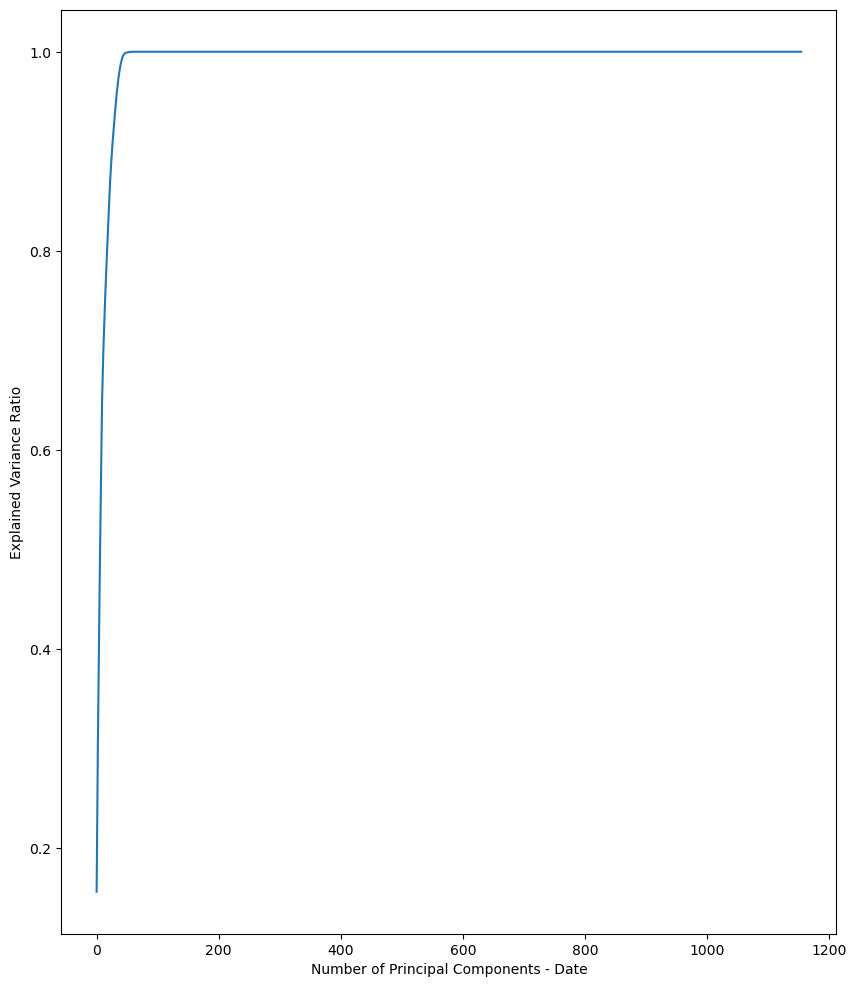

In [39]:
from pyspark.ml.feature import PCA
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import array
import numpy as np

df_date = df_date.drop('pca_features', 'features')

#Create instance of PCA
pca = PCA(k=len(df_date.columns) - 3, inputCol="scaled_features", outputCol="pca_cat_features")

# fit PCA model on dense features
pca_model = pca.fit(df_date)

#Transform the DataFrame
df_date = pca_model.transform(df_date)

# access the explained variance ratio for each principal component
explained_variance = pca_model.explainedVariance
pc_vs_variance = np.cumsum(pca_model.explainedVariance)

# plot the explained variance ratio
fig = plt.figure(figsize=(10, 12))
plt.plot(pc_vs_variance)
plt.xlabel('Number of Principal Components - Date')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [40]:
#### Reduce to 10 features per the explained variance ratio

In [41]:
df_date = df_date.drop('pca_features', 'features')

#Create instance of PCA
pca = PCA(k=10 , inputCol="scaled_features", outputCol="pca_date_features")

# fit PCA model on dense features
pca_model = pca.fit(df_date)

#Transform the DataFrame
df_date = pca_model.transform(df_date)

In [42]:
####### Dimensionality reduction of category dataset #####

In [43]:
### Reduce to 10 coulmns beceuase of resource constraints
df_category = df_category.select(df_category.columns[:10])


In [44]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

cols = [col for col in df_category.columns if col != 'Id' and col != 'Response']

#df_category = df_category.drop('features', 'scaled_features')

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

category_cols =[column for column in df_category.columns if column !='Id']
string_indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in category_cols ]

# Fit the pipeline on the input DataFrame
pipeline = Pipeline(stages=string_indexer)
df_category = pipeline.fit(df_category).transform(df_category)


In [50]:
# one-hot-encode category columns
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df_category = df_category.drop('L0_S2_F33_index', 'L0_S2_F35_index', 'L0_S2_F37_index', 'L0_S2_F39_index', 'L0_S2_F41_index')

categorical_columns = [col for col in df_category.columns if col.endswith('_index')]
encoders = []

# Loop through the categorical columns
for col in categorical_columns:  
    # Create a OneHotEncoder for the column
    encoder = OneHotEncoder(inputCol=col, outputCol=col + "_vec")
    encoders.append(encoder)

# Create a VectorAssembler to combine the one-hot encoded columns
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders], outputCol="features")

# Create a Pipeline to chain the indexers and encoders together
pipeline = Pipeline(stages=encoders + [assembler])

# Fit the pipeline on the input DataFrame
df_category = pipeline.fit(df_category).transform(df_category)

#df_category =  df_category.select(['Id'] + [col for col in df_category.columns if col.endswith('_vec')])

In [ ]:
####### PCA  Category dataset

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import array
import numpy as np

#df_category = df_category.drop('pca_features', 'features')

#Create instance of PCA
pca = PCA(k=4 , inputCol= 'features', outputCol="pca_cat_features")

# fit PCA model on dense features
pca_model = pca.fit(df_category)

#Transform the DataFrame
df_category = pca_model.transform(df_category)

# access the explained variance ratio for each principal component
explained_variance = pca_model.explainedVariance
pc_vs_variance = np.cumsum(pca_model.explainedVariance)

# plot the explained variance ratio
plt.plot(pc_vs_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [ ]:
### Category data is ignored as it has no impact

In [ ]:
###################### Data Integration ###########################

In [52]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

df_numeric = df_numeric.select(["Id", "Response", "pca_num_features"])
df_date = df_date.select(["Id", "pca_date_features"])
df_merged = df_numeric.join(df_date, on='Id', how='inner')#.join(df_category, on='Id', how='inner')


vectorAssembler = VectorAssembler(inputCols=["pca_num_features", "pca_date_features"],
                                  outputCol="pca_features")

df_merged = vectorAssembler.transform(df_merged)
df = df_merged.select(["Response", "pca_features"])

#print(df_merged.count())

In [53]:
########################################################

In [54]:
################# 5. Model development   ##############

In [55]:
########################################################

In [56]:
################# 1. LogisticRegression ###################

In [57]:
df1 = df.sample(False, 0.01, seed=123)


In [58]:
# Split data into train data and test data
(traindf, testdf) = df1.randomSplit([0.8, 0.2])

In [59]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Create the Logistic Regression model
lr = LogisticRegression(labelCol="Response", featuresCol="pca_features")

# Define the parameter grid to search over
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01, 0.001])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

# Define the binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Response")

# Create the cross-validator
cv = CrossValidator(estimator=lr, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=2)

# Fit the cross-validator to the data
cvModel = cv.fit(traindf)

# Extract the best model
bestModel = cvModel.bestModel

#Transform the test data using the best model to make predictions
predictions = bestModel.transform(testdf)



In [60]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

evaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol = 'Response')
accuracy_lr = evaluator.evaluate(predictions)
print("Accuracy: ", "{:.2f}%".format(accuracy_lr * 100))

evaluator = BinaryClassificationEvaluator(labelCol='Response', metricName='areaUnderPR')
precision_lr = evaluator.evaluate(predictions)
print("Precision: ", "{:.2f}%".format(accuracy_lr * 100))


Accuracy:  52.85%
Precision:  42.77%


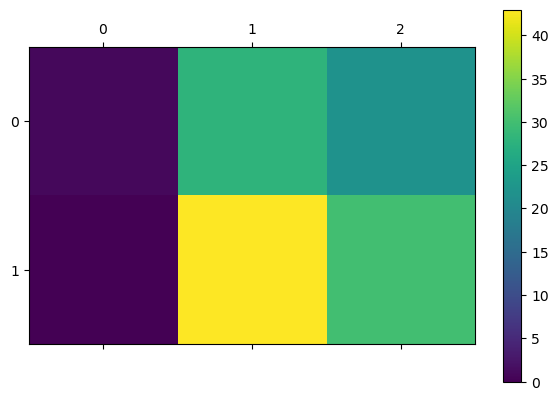

In [62]:
## Display confusion matrix
confusion_matrix_pd = confusion_matrix.toPandas().astype(float)
confusion_matrix_np = confusion_matrix_pd.to_numpy()

import matplotlib.pyplot as plt
plt.matshow(confusion_matrix_np)
plt.colorbar()


In [63]:
##################################################################

In [64]:
###### 2. ENSEMBLE STACKING   #####################################

In [65]:
########  First layer 1.XGBoosta and 2.RandomForestClassifier ############

In [66]:
# Split data into train data and test data
(training_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)


In [67]:

from pyspark.ml.classification import RandomForestClassifier
from xgboost.spark import SparkXGBRegressor

rf = RandomForestClassifier(labelCol="Response", featuresCol="pca_features", numTrees=20)
method_name = 'rf'
rf.setPredictionCol("prediction_" + method_name)
rf.setProbabilityCol("probability_" + method_name)
rf.setRawPredictionCol("raw_prediction_" + method_name)

xgb_regressor = SparkXGBRegressor(
  features_col="pca_features",
  label_col="Response",
  num_workers=2,
)

methods = {"xgboost": xgb_regressor,
          "random_forest": rf}


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

fitted_models ={}

# Iterate each model and evaluate the result
for method_name, method in methods.items():
    print('Executing ' + method_name)
    fitted_models[method_name] = method.fit(training_data)
    test_data = fitted_models[method_name].transform(test_data)
    
    # Evaluate the result
    evaluator = BinaryClassificationEvaluator(rawPredictionCol=("probability_rf" if method_name =='random_forest' else 'prediction'), labelCol="Response")
    if method_name =='random_forest':    
        accuracy_rf = evaluator.evaluate(test_data)
        print("Accuracy: ", "{:.2f}%".format(accuracy_rf * 100))
    else:
        accuracy_xgb = evaluator.evaluate(test_data)
        print("Accuracy: ", "{:.2f}%".format(accuracy_xgb * 100))
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol=("probability_rf" if method_name =='random_forest' else 'prediction'), metricName='areaUnderPR',labelCol="Response")
    if method_name =='random_forest':    
        precision_rf = evaluator.evaluate(test_data)
        print("Precision: ", "{:.2f}%".format(precision_rf * 100))
    else:
        precision_xgb = evaluator.evaluate(test_data)
        print("Precision: ", "{:.2f}%".format(precision_xgb * 100))


In [69]:
###  Ensemble Second layer model as a Random Forest Classifier ######

In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Select the variables from the test data to use for the second layer model
prediction_vars = [var for var in test_data.columns if var in ("probability_rf", "prediction")]

# Assemble the selected variables into a vector for the second layer model
vs_second_layers = VectorAssembler(inputCols= prediction_vars, outputCol= "second_layer_input")
test_data_transformed = vs_second_layers.transform(test_data)

# Define the second layer model as a Random Forest Classifier
second_layer = RandomForestClassifier(featuresCol= "second_layer_input", labelCol= "Response",  probabilityCol = "second_layer_output")

# Set the prediction and raw prediction columns for the second layer model
second_layer.setPredictionCol("prediction_second_layer")
second_layer.setRawPredictionCol("raw_prediction_second_layer" )

# Fit the second layer model to the transformed test data
model_second_layer = second_layer.fit(test_data_transformed)

# Generate predictions for the transformed test data using the second layer model
predictions_2 = model_second_layer.transform(test_data_transformed)


In [71]:
# Evaluate Accuracy and Precision
evaluator = BinaryClassificationEvaluator(rawPredictionCol='raw_prediction_second_layer', labelCol='Response')
accuracy = evaluator.evaluate(predictions_2)

evaluator = BinaryClassificationEvaluator(rawPredictionCol='raw_prediction_second_layer', labelCol='Response', metricName='areaUnderPR')
precision = evaluator.evaluate(predictions_2)

print("Accuracy: ", "{:.2f}%".format(accuracy * 100))
print("Precision: ", "{:.2f}%".format(precision * 100))


Accuracy:  82.32%
Precision:  80.95%


In [ ]:
# Evaluate Accuracy and Precision
evaluator = BinaryClassificationEvaluator(rawPredictionCol='raw_prediction_second_layer', labelCol='Response')
accuracy = evaluator.evaluate(predictions_2)

evaluator = BinaryClassificationEvaluator(rawPredictionCol='raw_prediction_second_layer', labelCol='Response', metricName='areaUnderPR')
precision = evaluator.evaluate(predictions_2)

print("Accuracy: ", "{:.2f}%".format(accuracy * 100))
print("Precision: ", "{:.2f}%".format(precision * 100))

In [ ]:
###### Compare the performance of the algorithms

In [72]:
#### Deployment ####

In [73]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 327.4 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 386.2 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 316.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 222.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 412.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 741.3 kB/s eta 0:00:00:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 430.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 kB 536.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 363.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 921.4 kB/s eta 0:00:00:--:--
  Created wheel for databricks-cli: filename=databricks_cli-0.1

_SklearnCustomModelPicklingError: Pickling custom sklearn model RandomForestClassificationModel failed when saving model: cannot pickle '_thread.RLock' object

In [ ]:
#### Invoke the deployed mode

In [ ]:
import requests
import json

# Make a prediction using the deployed MLflow Model
data = [{'feature_1': 10, 'feature_2': 20, 'new_feature': 200}]
response = requests.post("<MLflow REST API endpoint>/invocations", json=data)

# Print the prediction result
prediction = json.loads(response.text)
print("Prediction: ", prediction)
